### Hamid Pour Mohammad-98202938:

Final exam (part 2); MLP-2021.


### Introduction

In this code, I want to make the LSTM network, which can predict the air pollution. Actually, the goal is the prediction of pm2.5 units in the air of Tehran. I had collected the data from various sources (as you will see), and combined them together. Finally, the model works accurate and predicts well. 

In [1]:
### Imports:
import numpy as np
from datetime import datetime
import time
from pandas import date_range, read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras as ks

In [2]:
### Defining the functions:

# converting the string time to unix timestamp. For example: '2012-12-01' -> 1322697600.0:
def convert_string_to_date(x): 
    x = x.replace('-','/')
    return time.mktime(datetime.strptime(x,'%Y/%m/%d').timetuple())

# If the value of x is a number, then this function will return a number. Otherwise, it returns np.nan:
def int_or_nan(x):
    try: return int(x)
    except: return np.nan

# This function will clean every dataframe. Actually, it replaces the string date with the unix
# timestamp for each sample; and it replaces missed data with np.nan, and then replaces each 
# np.nan with mean (for each column):
def clean(df):
    df['date'] = df['date'].apply(lambda x: convert_string_to_date(x)) 
    # Please note that the first column always belongs to 'date'
    for i in range(1,len(df.keys())): # for every column; except 'date' column.
        df.iloc[:,i] = df.iloc[:,i].apply(lambda x: int_or_nan(x))
    df.fillna(df.mean(), inplace=True) # replacing each np.nan with mean (for each column)
    return df

# This function relates each day in week to a number. For example, Saturday -> 0, etc.
def number_of_day_in_week(x):
    day = time.strftime('%a', time.localtime(x))
    if day=='Sat': return 0
    elif day=='Sun': return 1
    elif day=='Mon': return 2
    elif day=='Tue': return 3
    elif day=='Wed': return 4
    elif day=='Thu': return 5
    elif day=='Fri': return 6
    else: return np.nan

'''
About 'combine()' function:

Since we have differend dataframes (from different sources and stations, with various durations), we need
a function to combine all these information. The function below is one of the most important functions
in all this code. It combines all different dataframes. For example, suppose two stations had reported SO_2
measures for a certain day; if station_1 reported 84 units of SO_2, and station_2 reported 82 units,
then the total amount of SO_2 units is 83 (average over all reported data). Generaly, the goal of this 
function is to put all information from all dataframes together, to build a single dataframe. 

Please note that I have two kinds of data: pollution and weather. Pollution's data contains 5 diffrent 
dataframes, for 5 different stations in Tehran. Weather's dataframe contains a single dataframe, from Imam's
Airport. Since the weather data is prepared from many years ago, so it's better that we don't consider very old
weather data. Because the pollution data has been prepared since 2015 (after 2014); while the weather data is 
prepared after 2005. Generating the data for such long duration doesn't seem to be logical; therefore, we just 
take care of the information which has been prepared after the oldest time that we have a reported pollution 
data.
'''
def combine(data):
    # let's make a date array, from the oldest time of data, to the newest:
    start_time = min( [min(df.iloc[:,0]) for df in data[:-1]] ) # find the oldest time for reported pollution
    end_time = max( [max(df.iloc[:,0]) for df in data[:-1]] ) # find the newest time for reported pollution
    duration = date_range(start=datetime.fromtimestamp(start_time), end=datetime.fromtimestamp(end_time))
    duration = [ time.mktime(d.timetuple()) for d in duration ][::-1]
    
    # now, let's find how many unique columns we have (all dataframes):
    columns_list=[]
    for df in data:
        for column in df.keys():
            if column not in columns_list: columns_list+=[column]
    # here, I am going to make a dataframe, that contains all the data:
    df_all = np.full( [ len(duration), len(columns_list) ], np.nan )
    df_all = df_all.T
    df_all[0] = duration
    df_all = df_all.T
    
    print('Please wait for combining all dataframes...')
    
    columns_list.remove('date') # because 'date' is not a feature; anyway, I will add 'date' column later.
    for i in range(len(df_all)):
        for j in range(len(columns_list)):
            value, value_count = 0, 0
            for df in data:
                try: 
                    # finding all the reported data a certain day and average over them:
                    value += int(round(df[df['date']==df_all[:,0][i]][columns_list[j]]))
                    value_count += 1 # how many data we have for that certain day
                except: pass
            # averaging over reported data for that certain day (if we have at least 1 reported data):
            if value_count: 
                df_all[i][j+1] = value/value_count
                
    columns_list = ['date']+columns_list
    df_all = DataFrame(df_all, columns=columns_list) # now, we want to convert the array to dataframe
    df_all.fillna(df_all.mean(), inplace=True) # filling np.nan data with the mean (for each column)
    # what day are we exploring? I think it's important, because Fridays are not like Saturdays!
    df_all['day_number'] = df_all['date'].apply(lambda x: number_of_day_in_week(x))
    print('Combining finished.')
    return df_all

# This function converts simple features (for each day) to time series features:
def make_time_series(features, n_ts):
    def shifter(column, shift): # shifting a column of data for a certain number of days
        return ( list(column)[:-shift] + [np.nan]*shift )
    columns_names = features.keys()
    new_features = features
    for i in range(1, n_ts+1): # a loop to make different time series
        for col in columns_names:
            new_features[col+ f' (d-{i})'] = shifter( features[col], i )
    return new_features.drop(columns_names, axis=1)

# getting rid of np.nan values, after building the time series:
def get_rid__n_ts__nan(new_features, target, n_ts):
    return new_features.iloc[:len(new_features)-n_ts,:] ,  target.iloc[:len(target)-n_ts] 

In [3]:
### Importing the data:

'''
I have two kinds of data: pollution and weather. pollution's data contains 5 diffrent 
dataframes, for 5 different stations in Tehran. Weather's dataframe contains a single dataframe, from Imam's
Airport. Since the weather data is prepared from many years ago, so it's better that we don't consider very old 
weather data. Because the pollution data has been prepared since 2015 (after 2014); while the weather data is 
prepared after 2005. Generating the data for such long duration doesn't seem to be logical; therefore, we just 
take care of the information which has been prepared after the oldest time that we have a reported pollution 
data.

Pollution's stations: sharif_university, tehran_university, razi, golbarg, and shad_abad station (all in Tehran)
Weather's station: Imam's Airport station (Tehran International Airport)

I downloaded the pollution's dataframes from: https://aqicn.org/data-platform/register/
Also, I downloaded the weather's dataframe from: https://meteostat.net/en/station/40730?t=2019-01-01/2019-12-31
(All the data are daily)

'''


data = [
    clean( read_csv('data_sharif_university.csv') ) , # pollution
    clean( read_csv('data_tehran_university.csv') ) , # pollution
    clean( read_csv('data_razi.csv') ) , # pollution
    clean( read_csv('data_golbarg.csv') ) , # pollution
    clean( read_csv('data_shad_abad.csv') ) , # pollution
    clean( read_csv('data_weather.csv')[['date', 'wind_speed', 'wind_direction', 'temp_avg', # Weather
                                         'temp_max', 'temp_min', 'pressure']] ) ]

print('Lets look at one of these data:')
data[0]

Lets look at one of these data:


,date,pm25,pm10,o3,no2,so2,co
0,1.622489e+09,89.000000,52.000000,37.310105,54.00000,8.000000,28.532902
1,1.622576e+09,101.000000,66.583553,37.310105,41.70384,11.681648,28.532902
2,1.622835e+09,93.000000,50.000000,37.310105,33.00000,6.000000,28.532902
3,1.622921e+09,91.000000,60.000000,37.310105,39.00000,8.000000,28.532902
4,1.623008e+09,87.000000,53.000000,37.310105,48.00000,8.000000,28.532902
...,...,...,...,...,...,...,...
1770,1.455827e+09,103.749458,66.583553,424.000000,18.00000,18.000000,28.532902
1771,1.467229e+09,103.749458,66.583553,37.310105,90.00000,12.000000,28.532902
1772,1.449088e+09,103.749458,66.583553,37.310105,20.00000,13.000000,23.000000
1773,1.449175e+09,103.749458,66.583553,37.310105,14.00000,11.681648,34.000000


In [4]:
# let's see the shape of each dataframe:
for i in range(len(data)):
    print(f'Shape of data_{i}: {data[i].shape}')

Shape of data_0: (1775, 7)
Shape of data_1: (1015, 5)
Shape of data_2: (938, 5)
Shape of data_3: (1753, 7)
Shape of data_4: (1750, 7)
Shape of data_5: (4569, 7)


In [5]:
%%time
# Now, let's combine all of the dataframes to make a single dataframe:
df_all = combine(data)
df_all # as you can see, I have 13 certain features

Please wait for combining all dataframes...
Combining finished.
CPU times: user 1min 27s, sys: 173 ms, total: 1min 28s
Wall time: 1min 28s


,date,pm25,pm10,o3,no2,so2,co,wind_speed,wind_direction,temp_avg,temp_max,temp_min,pressure,day_number
0,1.623785e+09,114.750000,65.666667,40.666667,44.750000,15.250000,26.250000,18.000000,116.000000,32.000000,39.00000,24.000000,1008.000000,4
1,1.623699e+09,91.750000,77.666667,40.666667,63.000000,11.500000,24.000000,14.000000,31.000000,30.000000,38.00000,22.000000,1008.000000,3
2,1.623613e+09,85.600000,69.666667,40.666667,43.000000,13.400000,22.800000,28.000000,307.000000,30.000000,39.00000,23.000000,1008.000000,2
3,1.623526e+09,105.600000,68.333333,40.666667,41.400000,12.400000,21.800000,13.000000,319.000000,30.000000,40.00000,22.000000,1007.000000,1
4,1.623440e+09,85.600000,68.000000,40.666667,48.400000,18.000000,29.400000,17.000000,332.000000,30.000000,39.00000,22.000000,1007.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318,1.423514e+09,122.666667,73.333333,23.666667,38.666667,17.333333,31.333333,7.000000,258.000000,9.000000,14.00000,7.000000,1015.000000,3
2319,1.423427e+09,74.000000,85.333333,24.333333,50.333333,20.000000,41.333333,14.797254,255.336384,17.834783,24.75286,11.843478,1014.918078,2
2320,1.423341e+09,93.000000,65.333333,24.000000,51.333333,20.333333,43.000000,16.000000,258.000000,11.000000,16.00000,5.000000,1015.000000,1
2321,1.423255e+09,78.666667,64.333333,28.666667,57.000000,20.333333,37.333333,9.000000,258.000000,6.000000,14.00000,-1.000000,1015.000000,0


In [6]:
dates = df_all['date']
scaler = MinMaxScaler() # Let's start to scale
features = df_all.drop(['date'], axis=1)
scaler.fit(features)
features = DataFrame(scaler.transform(features), columns=list(features.keys()))
target = features[' pm25'] # My target is to predict the pm25 (or so called pm2.5) units in the air of Tehran
n_f = len(features.keys()) # Number of features
features # (as I said, there are 13 certain features)

,pm25,pm10,o3,no2,so2,co,wind_speed,wind_direction,temp_avg,temp_max,temp_min,pressure,day_number
0,0.568404,0.201717,0.196277,0.370192,0.196884,0.249310,0.405405,0.323120,0.880952,0.732143,0.813953,0.25000,0.666667
1,0.418567,0.253219,0.196277,0.580769,0.133144,0.224471,0.297297,0.086351,0.833333,0.714286,0.767442,0.25000,0.500000
2,0.378502,0.218884,0.196277,0.350000,0.165439,0.211224,0.675676,0.855153,0.833333,0.732143,0.790698,0.25000,0.333333
3,0.508795,0.213162,0.196277,0.331538,0.148442,0.200184,0.270270,0.888579,0.833333,0.750000,0.767442,0.21875,0.166667
4,0.378502,0.211731,0.196277,0.412308,0.243626,0.284085,0.378378,0.924791,0.833333,0.732143,0.767442,0.21875,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318,0.619978,0.234621,0.109983,0.300000,0.232295,0.305428,0.108108,0.718663,0.333333,0.285714,0.418605,0.46875,0.500000
2319,0.302932,0.286123,0.113367,0.434615,0.277620,0.415823,0.318845,0.711243,0.543685,0.477730,0.531244,0.46619,0.333333
2320,0.426710,0.200286,0.111675,0.446154,0.283286,0.434223,0.351351,0.718663,0.380952,0.321429,0.372093,0.46875,0.166667
2321,0.333333,0.195994,0.135364,0.511538,0.283286,0.371665,0.162162,0.718663,0.261905,0.285714,0.232558,0.46875,0.000000


In [7]:
n_ts = 6 # number of previous days that we want to consider
new_features = make_time_series(features, n_ts) # now, let's make the time series

# we want to get rid of np.nan in data samples (after making the time series):
X, Y =  get_rid__n_ts__nan(new_features, target, n_ts)

In [8]:
print(f'shape of X before reshaping the time series: {X.shape}')
X = X.values.reshape(-1, n_ts, n_f)
print(f'shape of X after reshaping the time series: {X.shape}')

shape of X before reshaping the time series: (2317, 78)
shape of X after reshaping the time series: (2317, 6, 13)


In [9]:
n_future = 100 # keep some data of future, to testify another time (except the validation)
X_future = X[-n_future:].copy()
Y_future = Y[-n_future:].copy()

X = X[:-n_future]
Y = Y[:-n_future]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

X_train.shape

(1662, 6, 13)

In [10]:
'''
Now, it's time to build the model. I have checked different conditions (fine tunning); different number of 
layers and units; different values for learning_rate, regularization, etc. Finally, I have made a useful model,
that can predict well.
'''
model = ks.models.Sequential()
model.add(ks.layers.LSTM(128, input_shape=(n_ts, n_f)))
model.add(ks.layers.Dropout(0.1))
model.add(ks.layers.Dense(32, activation='relu', kernel_regularizer=ks.regularizers.L2(0.01)))
model.add(ks.layers.Dense(1, activation='linear'))

model.compile(loss=ks.losses.mean_squared_error, optimizer=ks.optimizers.SGD(0.05))
# model.summary() # There are 76,865 parameters in total; all trainable.

Epoch 1/20
333/333 [==============================] - 5s 8ms/step - loss: 0.3814 - val_loss: 0.2653
Epoch 2/20
333/333 [==============================] - 2s 6ms/step - loss: 0.1952 - val_loss: 0.1383
Epoch 3/20
333/333 [==============================] - 2s 6ms/step - loss: 0.1016 - val_loss: 0.0719
Epoch 4/20
333/333 [==============================] - 2s 6ms/step - loss: 0.0536 - val_loss: 0.0382
Epoch 5/20
333/333 [==============================] - 2s 7ms/step - loss: 0.0288 - val_loss: 0.0207
Epoch 6/20
333/333 [==============================] - 2s 6ms/step - loss: 0.0160 - val_loss: 0.0124
Epoch 7/20
333/333 [==============================] - 2s 6ms/step - loss: 0.0092 - val_loss: 0.0070
Epoch 8/20
333/333 [==============================] - 2s 7ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 9/20
333/333 [==============================] - 2s 7ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 10/20
333/333 [==============================] - 2s 7ms/step - loss: 0.0027 - val_loss: 0.0022

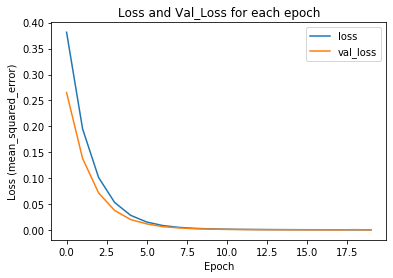

In [11]:
%%time
history = model.fit(X_train, Y_train, epochs=20, batch_size=5, verbose=1, validation_data=(X_test, Y_test))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'), plt.ylabel('Loss (mean_squared_error)')
plt.title('Loss and Val_Loss for each epoch')
plt.legend()

In [12]:
# Please note: Loss is greater than the Validation_Loss; it's because of using Dropout.

In [13]:
# Now, let's define the score function:
def score(Y_real, Y_pred, epsilon=10**(-9)):
    return 1 - np.mean( np.abs(Y_real-Y_pred) / (Y_real+Y_pred+epsilon) )

train_score = score(np.array(Y_train).reshape(len(Y_train),1), model.predict(X_train)) # for training data
prediction_score = score(np.array(Y_future).reshape(len(Y_future),1), model.predict(X_future)) # for future data
print(f'Training Score: {round(train_score, 3)}')
print(f'Predicting Score: {round(prediction_score, 3)}')

Training Score: 0.99
Predicting Score: 0.986


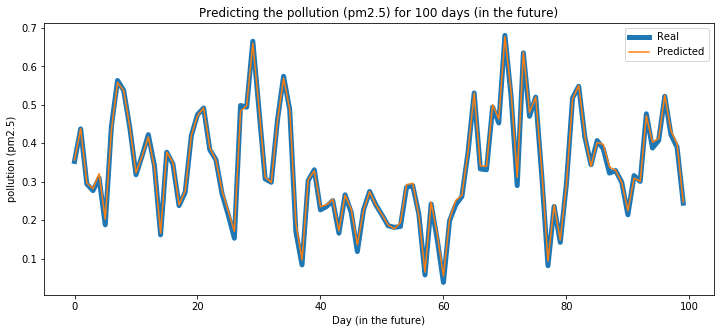

In [15]:
# Plotting the real values and predictions of pollution for 100 days (future):
plt.figure(figsize=(12,5))
plt.plot(list(Y_future), lw=5, label='Real')
plt.plot(model.predict(X_future), label='Predicted')
plt.xlabel('Day (in the future)'), plt.ylabel('pollution (pm2.5)')
plt.title('Predicting the pollution (pm2.5) for 100 days (in the future)')
plt.legend()

Please note that the values of pm2.5 units had been scaled by MinMaxScaler. They can be rescaled back if you would rather; anyway, I think the efficiency of the model is completely obvious as you can see.

In [16]:
### Saving the model:
model.save('saved_model.h5')

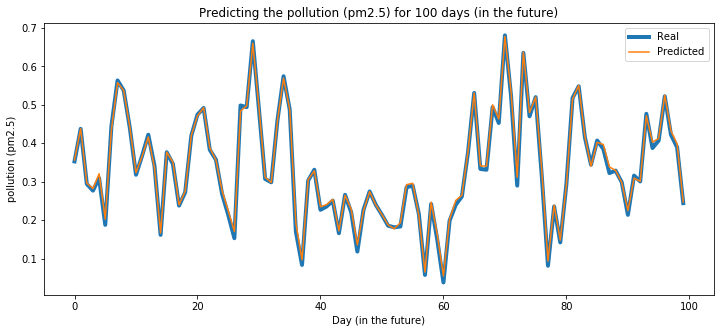

In [17]:
### Load the saved model:
# If you want to save your time, you can use the saved model. Remember that you should load the dataset, if
# you did not; so run the first 9 cells, to prepare the data.
model=ks.models.load_model('saved_model.h5')
plt.figure(figsize=(12,5))
plt.plot(list(Y_future), lw=4, label='Real')
plt.plot(model.predict(X_future), label='Predicted')
plt.xlabel('Day (in the future)'), plt.ylabel('pollution (pm2.5)')
plt.title('Predicting the pollution (pm2.5) for 100 days (in the future)')
plt.legend()